In [1]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio
%matplotlib inline

In [2]:
from GPSPhoto import gpsphoto
from pyproj import Proj, transform
import cv2

In [3]:
json_folder = r"C:\Users\James Cho G7\Documents\James Python\DS\Drone\Geojson"
img_folder = r'C:\Users\James Cho G7\Documents\James Python\DS\Drone\TIFF\interbulgo'
jpg_folder = r'D:\drone images\Unknown'

In [4]:
TClient = '그레이스'
src_crs = '5179'
dst_crs = '4326'

In [5]:
files = glob.glob(os.path.join(img_folder,'*.tiff'))

files = [x for x in files if (TClient in x)]
files

['C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\TIFF\\interbulgo\\그레이스 5179.tiff']

#### 이미지를 읽어온다 Raterio활용. crs를 5179로

In [6]:
import rasterio

wgs84_crs = rasterio.crs.CRS({"init": "epsg:4326"})
e5179_crs = rasterio.crs.CRS({"init": "epsg:5179"})

dataset = rasterio.open(files[0], mode='r+')
dataset.crs = e5179_crs
dataset.crs

CRS.from_epsg(5179)

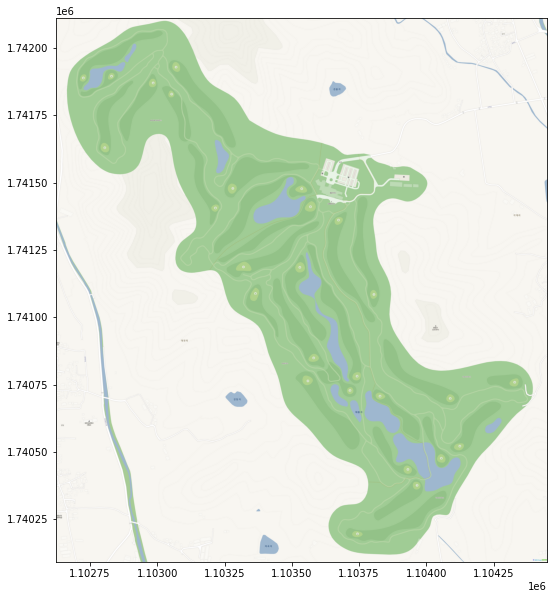

<AxesSubplot:>

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(dataset.read(), transform=dataset.transform)

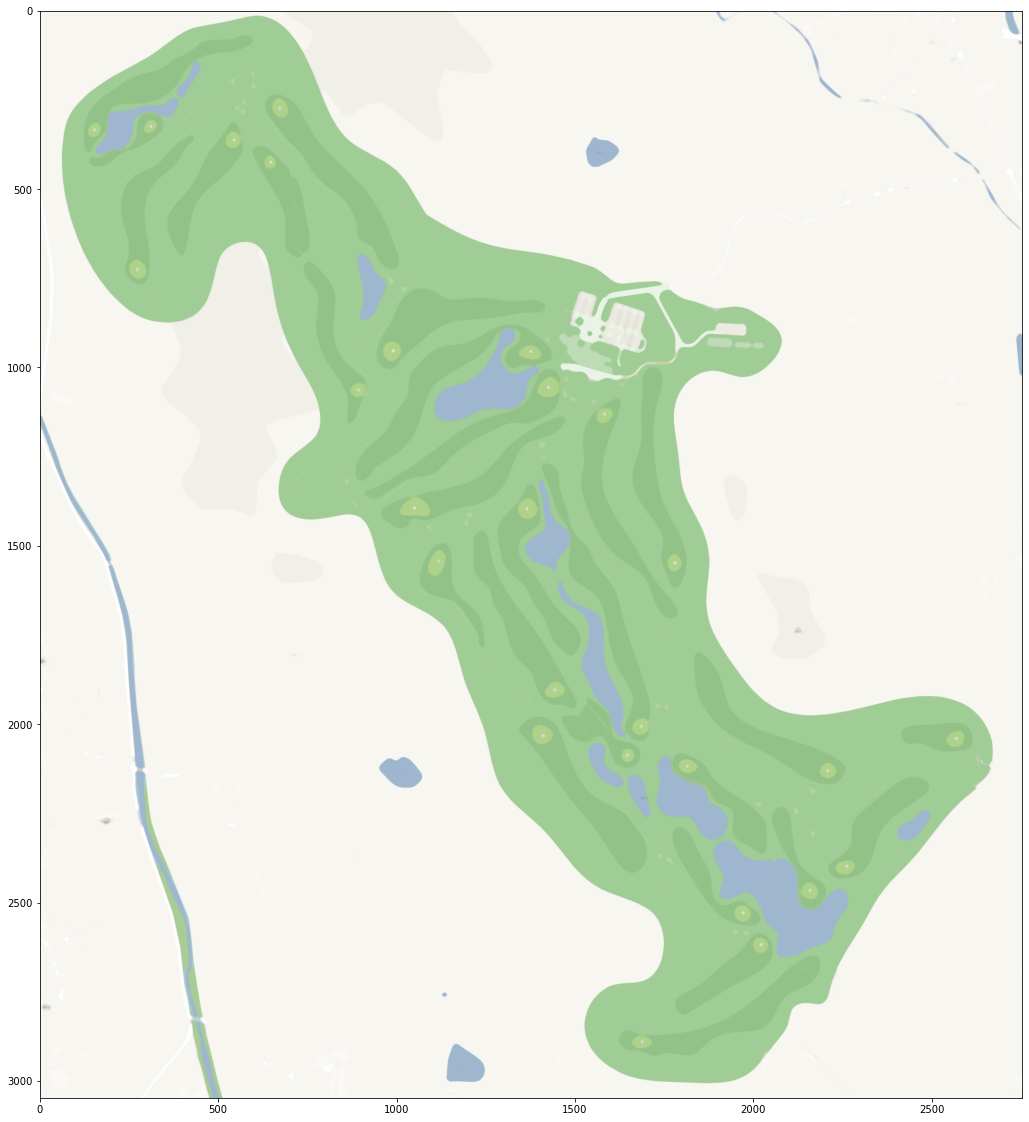

In [8]:
im1 = dataset.read()
im1 = im1.transpose(1, 2, 0)[:,:,:3]
im1_blurred = cv2.medianBlur(im1, 15)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(im1_blurred)

In [9]:
pixel_values = im1.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(im1.shape)

# segmented_image = cv2.medianBlur(segmented_image, 9)

# sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# im1_blurred = cv2.filter2D(im1_blurred , -1, sharpen_kernel)

In [10]:
# fig, ax = plt.subplots(figsize=(20, 20))
cv2.imshow("Window", segmented_image )
cv2.waitKey(0)
cv2.destroyAllWindows()

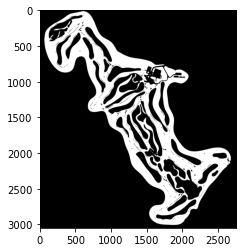

In [11]:
sought = [139,215,175]


lobound_ = (154,199,143)
hibound_ = (164,209,152)

# mask = np.all(im1_blurred==sought,axis=2) * np.uint8(255)

mask = cv2.inRange(im1_blurred, lobound_, hibound_)
plt.imshow(mask, cmap = 'gray')

In [12]:
contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [13]:
image_copy = im1_blurred.copy()
# c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255,1,1), thickness=1, lineType=cv2.LINE_AA)

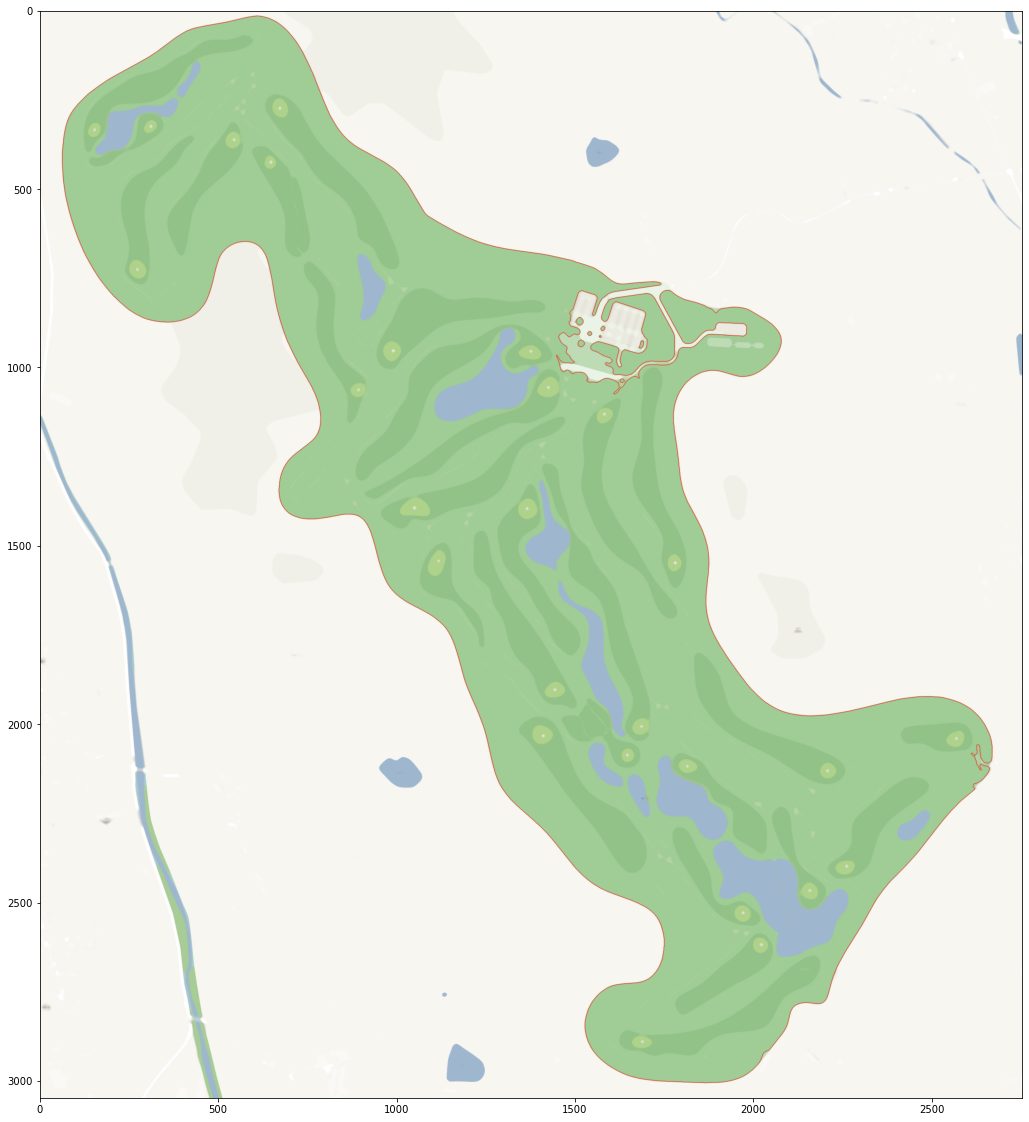

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(image_copy)

In [15]:
approx_contours = []

for c in contours:
    epsilon = 0.001*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)
    
    if cv2.contourArea(c) > 100:
        approx_contours.append(approx)
    print(c.shape,approx.shape)

(32, 1, 2) (20, 1, 2)
(51, 1, 2) (22, 1, 2)
(51, 1, 2) (32, 1, 2)
(14, 1, 2) (8, 1, 2)
(31, 1, 2) (19, 1, 2)
(32, 1, 2) (21, 1, 2)
(56, 1, 2) (29, 1, 2)
(1143, 1, 2) (70, 1, 2)
(11092, 1, 2) (105, 1, 2)


In [16]:
len(approx_contours)

6

In [17]:
image_copy = im1_blurred.copy()
# c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=[approx_contours[-1]], 
                              contourIdx=-1, color=(255,1,1), thickness=1, lineType=cv2.LINE_AA)

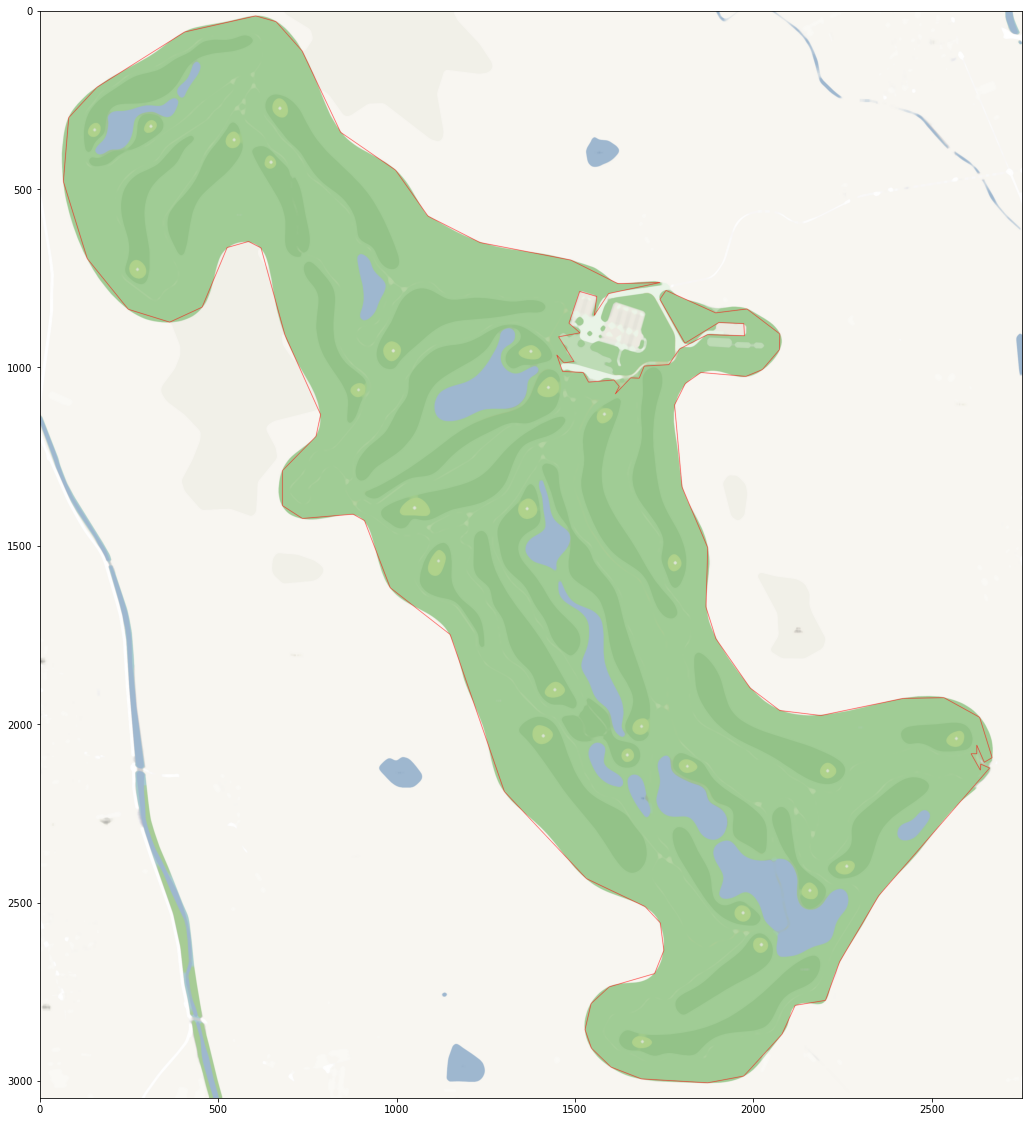

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(image_copy)

In [19]:
contours = [approx_contours[-1]]

In [20]:
def convert_latlon(a,dataset_):
    return dataset_.xy(a[1],a[0])

In [21]:
from shapely.geometry import Polygon


con_geo = []
for i,contour in enumerate(contours):
    con_single = np.squeeze(np.apply_along_axis(lambda p: convert_latlon(p, dataset), -1, contour))
    
    try:
        con_single = Polygon(con_single)
        con_geo.append(con_single)
    except:
        pass
        



In [22]:
con_geo

In [23]:
gdf = gpd.GeoSeries(con_geo, crs=int(src_crs))
gdf.crs

<Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
gdf = gdf.to_crs(int(dst_crs))
gdf = gpd.GeoDataFrame(geometry=gdf)

In [25]:
gdf['Name']= 'Contour_' + gdf.index.astype(str)
gdf['Client'] = TClient

gdf['Course'] = '전체'
gdf['Hole'] = 0

gdf['Type'] = '전면'
gdf['TypeId'] = 0

In [26]:
gdf = gdf[['Name','Client','Course','Hole','Type','TypeId','geometry']]

In [27]:
gdf

,Name,Client,Course,Hole,Type,TypeId,geometry
0,Contour_0,그레이스,전체,0,전면,0,"POLYGON ((128.63687 35.66948, 128.63506 35.668..."


In [44]:
gdf.to_file(os.path.join(json_folder,TClient+'_전면_'+dst_crs+'.shp'))

In [45]:
gdf.to_file(os.path.join(json_folder,TClient+'_전면_'+dst_crs+'.geojson'), driver='GeoJSON')

## QGIS로 가서 shp화일을 일어서 코스별로 나눈다.
골프징 이름 + 코스 로 저장

In [47]:
files = glob.glob(os.path.join(json_folder,'*'))

files = [x for x in files if ('geojson' in x) and ('코스' in x) and (TClient in x)]

t_file = files[-1]
t_file

'C:\\Users\\James Cho G7\\Documents\\James Python\\DS\\Drone\\Geojson\\그레이스_코스_4326.geojson'

In [48]:
from shapely.geometry import MultiPolygon, Polygon

gdf = gpd.read_file(t_file)
gdf = gdf.explode()

In [49]:
gdf

,,Name,Client,Course,Hole,Type,TypeId,geometry
0,0,Contour_0,????,??,0,??,0,"POLYGON ((128.64477 35.66558, 128.64466 35.665..."
1,0,Contour_0,????,??,0,??,0,"POLYGON ((128.64646 35.65418, 128.64729 35.654..."
2,0,Contour_0,????,??,0,??,0,"POLYGON ((128.64548 35.66357, 128.64493 35.663..."


In [50]:
gdf['Client'] = TClient
gdf['Hole'] = 0

gdf['Type'] = '코스'
gdf['TypeId'] = 0

In [52]:
gdf.to_file(t_file, driver='GeoJSON')

geojson io로 가서 shp화일을 일어서 코스별로 나눈다.¶
골프징 이름 + 코스 로 저장